# WASP-117

**Note**: Can't run this planet, TTVs are needed.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lightkurve as lk
from glob import glob
import ombre as om
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import pymc3_ext as pmx
import exoplanet as xo
import astropy.units as u

In [3]:
name = 'CD-50-714'

In [4]:
fnames = np.asarray(glob(f'/Volumes/Nibelheim/hst/data/{name}/*.fits'))

In [15]:
obs = om.Observation.from_files(fnames)

In [16]:
obs

CD-50-714 [1 planets, 2 Visits]

In [17]:
obs.nplanets

1

In [21]:
clc = lk.search_lightcurve('WASP-117', author='SPOC', exptime=120).download_all().stitch(lambda x: x.normalize()).remove_nans()
bls = clc.to_periodogram('bls', minimum_period=10, maximum_period=10.05, duration = np.linspace(0.01, 0.5, 50), frequency_factor=100)


In [22]:
clc.flux = clc.flux.value * u.electron/u.s
clc.flux_err = clc.flux_err.value * u.electron/u.s

obs.period, obs.t0, obs.duration = np.atleast_2d([bls.period_at_max_power.value, bls.transit_time_at_max_power.value + 2457000, bls.duration_at_max_power.value]).T

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

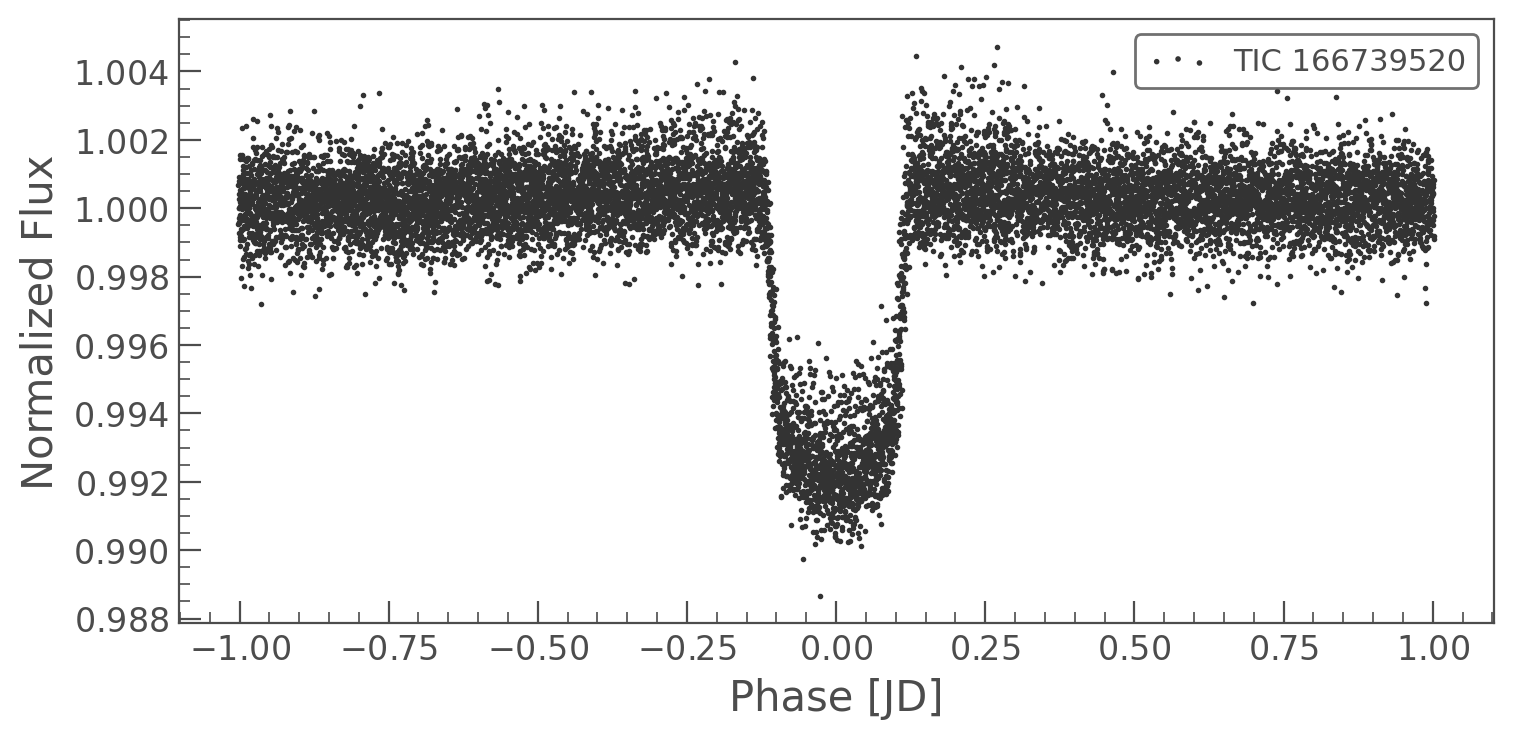

In [23]:
k = np.abs(((clc.time.value - (obs.t0[0] - 2457000 + obs.period[0]/2))/obs.period[0]) % 1 - 0.5) < 0.1
clc[k].fold(obs.period[0], obs.t0[0] - 2457000).scatter()

In [30]:
obs.fit_transit(x_suppl=clc.time.value[k] + 2457000,
                y_suppl=clc.flux.value[k],
                yerr_suppl=clc.flux_err.value[k],
                exptime_suppl=np.median(np.diff(clc.time.value)), fit_t0=True, fit_period=True, fit_inc=True, calc_eclipse=False, ttv=False)

optimizing logp for variables: [r_suppl, inc, r, m_star, r_star, u, u_suppl, period, t0, norm_suppl]


message: Desired error not necessarily achieved due to precision loss.
logp: -45325.72445793535 -> 63774.19690727302


<AxesSubplot:xlabel='Time [JD]', ylabel='$e^-s^{-1}$'>

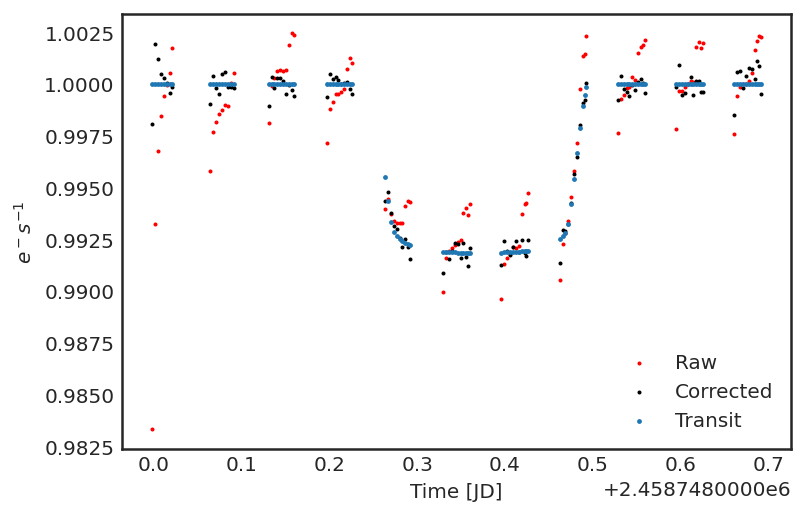

In [31]:
obs[0].plot()

In [32]:
obs.fit_model()

Fitting Transit/Eclipse Model: 100%|██████████████| 2/2 [01:06<00:00, 33.08s/it]


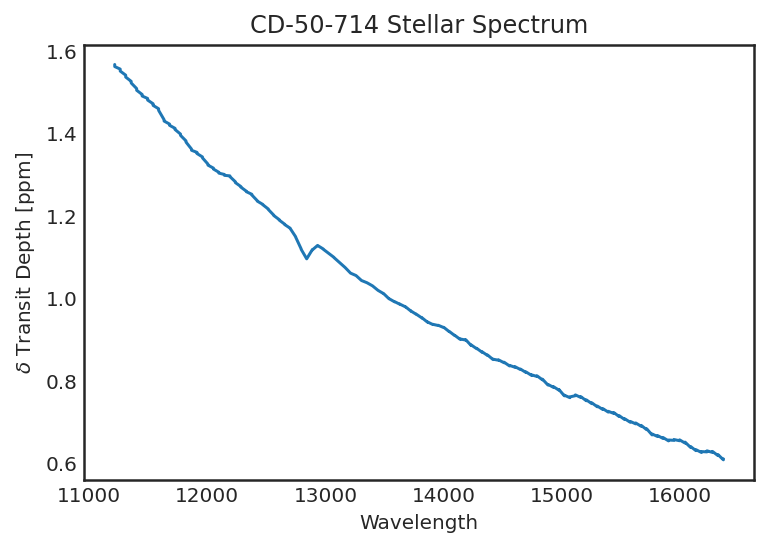

In [33]:
spec = obs.stellar_spectra
spec.plot()
spec.hdulist.writeto(f'results/{name}_stellar_spectrum.fits', overwrite=True)

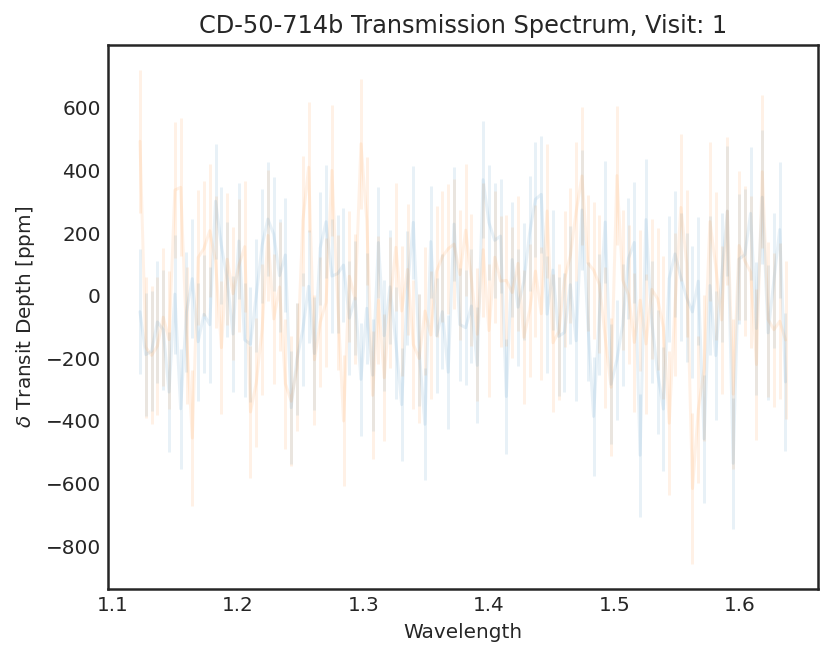

In [35]:
obs.plot_spectra('b')

In [ ]:
for visit in obs:
    visit.diagnose()
    visit.plot_residual_panel()

In [ ]:
# ax = om.Spectra([visit.transmission_spectrum for visit in obs]).flatten().bin(bins=np.linspace(0.8, 1.7, 150)).plot()
# ax.set(title='WASP-107 Transmission Spectrum')

In [ ]:
from astropy.io import fits
try:
    hdulist = om.Spectra([visit.transmission_spectrum for visit in obs if visit.transmission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_transmission.fits')
except:
    pass
try:    
    hdulist = om.Spectra([visit.emission_spectrum for visit in obs if visit.emission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_emission.fits')
except:
    pass

In [ ]:
for visit in obs:
    visit.diagnose();
    plt.show();